To do:
- Remove multicollinearity
- Interpret regression results
- Run again with larger set
    * See if expectations match up
    * Write up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(8,8))
sns.set_style('darkgrid')

In [3]:
def scale_feat(X, y):
    """Performs min-max feature scaling on features and response
    
    Args:
        X(df/arr): A dataframe or array of features
        y(arr): A array of response values 
    Returns:
        X(arr): A transformed array whose values are (0,1)
        y(arr): A transformed array whose values are (0,1)
    """
    scaler = MinMaxScaler()

    scaler.fit(X)
    scaler.fit(y)

    X = scaler.transform(X)
    y = scaler.transform(y)
    
    return X, y

In [19]:
def feature_processing(df, feat_col, target):
    # Separating features and target
    reg_feat = df.loc[:, feat_col]
    reg_target = df[target].values.reshape(-1, 1)
    
    # Feature scaling
    reg_feat, reg_target = scale_feat(reg_feat, reg_target)
    
    # lm data preprocessing
    X_train, X_test, y_train, y_test = train_test_split(reg_feat, reg_target, test_size=0.2, random_state=50)
    
    return X_train, X_test, y_train, y_test

In [20]:
def create_lm(df, feat_col, target):
    """Creates a linear model from a dataframe and performs model validation. 
    Steps:
        1. Seperate features and target
        2. Performs min-max scaler on features and target
        3. Creates a linear model
        4. Validates linear model
        
    Args:
        df(df): Contains both features and target
        feat_col(list): A list of feature names
        target(str): The name of the target column
    
    Returns:
        lm: A instance of a LinearRegression()
        r_sqr(float): A goodness of fit for the model
        mse(float): The MSE of predicted and actual target values
    """
    # lm data preprocessing
    X_train, X_test, y_train, y_test = feature_processing(df, feat_col, target)
    
    
    lm = LinearRegression().fit(X_train, y_train)
    
    lm_pred = lm.predict(X_test)
    r_sqr = lm.score(X_test, y_test)
    mse = mean_squared_error(y_test, lm_pred)
    
    print('Model Validation',
         '\nR^2 = ', r_sqr,
         '\nMean squared error = ', mse)
    
    return lm, r_sqr, mse

In [21]:
def lm_details(df, feat_col, target):
    
    X_train, X_dummy, y_train, y_dummy = feature_processing(df, feat_col, target)
    
    df_sm_ready = sm.add_constant(X_train)
    sm_general_model = sm.OLS(y_train, df_sm_ready)
    sm_fitted_model = sm_general_model.fit()
    
    print(sm_fitted_model.summary())
    return sm_fitted_model, X_train

In [22]:
def vif_multicollinearity(df):
    
    reg_feat = sm.add_constant(df)
    output_df = pd.DataFrame()
    
    output_df['feature'] = reg_feat.columns
    output_df['vif'] = [variance_inflation_factor(reg_feat.values, col) for col in range(reg_feat.shape[1])]
    
    return output_df

In [23]:
regression_short = pd.read_csv('../data/processed/regression_short.csv')
regression_long = pd.read_csv('../data/processed/regression_long.csv')

In [24]:
feat = list(regression_short.iloc[:,2:])
target = 'state_FOODINSEC_13_15'

lm, rs, mse = create_lm(regression_short, feat, target)

Model Validation 
R^2 =  0.7944726739576555 
Mean squared error =  0.007876824674454675


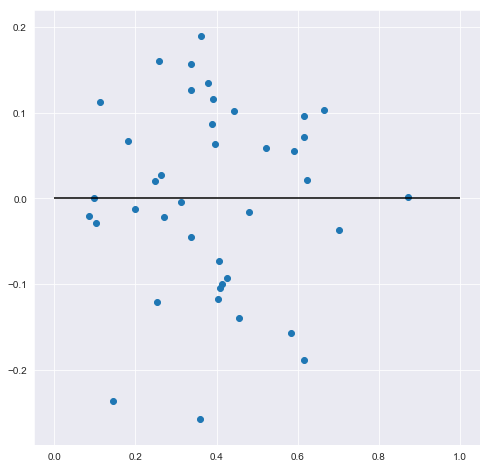

In [32]:
X_train, X_test, y_train, y_test = feature_processing(regression_short, feat, target)

plt.scatter(lm.predict(X_train), lm.predict(X_train)-y_train)
plt.hlines(y=0, xmin=0, xmax=1)

In [16]:
test, sm_X_train = lm_details(regression_short, feat, target)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     18.64
Date:                Thu, 06 Jun 2019   Prob (F-statistic):           6.88e-09
Time:                        16:25:23   Log-Likelihood:                 31.845
No. Observations:                  40   AIC:                            -51.69
Df Residuals:                      34   BIC:                            -41.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2562      1.633      0.157      0.8

Originally used LACCESS_POP15 (Population, low access to store, 2015) and LACCESS_LOWI15 (Low income & low access to store, 2015). I would expect the features to be highly correlated, as LACCESS_LOWI15 is a subset of LACCESS_POP15. This is confirmed by the variance inflation factor and explains why the high p-value in the regression. Replacing LACCESS_LOWI15 with another uncorrelated feature should improve LACCESS_POP15's p-value and increase the accuracy of the model. I chose PCT_OBESE_ADULTS13 as the feature to replace LACCESS_LOWI15.

Rerunning the variance inflation factor we see that all the feature VIFs are below 5, meaning I have eliminated multicollinearity between features. This allows us to have confidence in the results of the regression. Because SKLearn does not have a built-in p-value for the coefficients I ran a statsmodel OSL. With a standard $\alpha$ = 0.05 the only significant feature is state_FOODINSEC_10_12 (x1). Using the features from regression_short the only reliable predictor for state_FOODISEC_13_15 is state_FOODINSEC_10_12.

In [11]:
vif_multicollinearity(pd.DataFrame(sm_X_train))

,feature,vif
0,const,7606.433946
1,0,1.412887
2,1,1.923089
3,2,1.506121
4,3,2.376568
5,4,1.377798


In [12]:
pd.DataFrame(list(zip(feat, lm.coef_.T)), columns=['feature', 'estimated_coefficient'])

,feature,estimated_coefficient
0,state_FOODINSEC_10_12,[0.7835543272892759]
1,state_LACCESS_POP15,[-2.9112719526372215e-06]
2,state_PCT_OBESE_ADULTS13,[0.19796610505232623]
3,state_MEDHHINC15,[-8.310355490135413e-06]
4,state_GROCPTH14,[0.7570747259988256]


In [9]:
feat_long = list(regression_long.iloc[:,2:])
target_long = 'state_FOODINSEC_13_15'

lm_long, rs_long, mse_long = create_lm(regression_long, feat_long, target_long)

Model Validation 
R^2 =  0.5618270988027214 
Mean squared error =  0.01679295491401969


In [37]:
# Ridge Regression
X_train, X_test, y_train, y_test = feature_processing(regression_long, feat_long, target_long)

clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
pd.DataFrame(list(zip(feat_long, clf.coef_.T)), columns=['feature', 'estimated_coefficient'])

,feature,estimated_coefficient
0,state_FOODINSEC_10_12,[0.35172467665148754]
1,state_LACCESS_POP15,[-1.0876247389403158e-06]
2,state_PCT_FREE_LUNCH14,[0.031313453697407394]
3,state_PCT_OBESE_ADULTS13,[0.14207409644473415]
4,state_RECFACPTH14,[-0.001375538130882425]
5,state_FFRPTH14,[0.0005549646154776942]
6,state_FSRPTH14,[-0.008785341809078955]
7,state_PCT_NHWHITE10,[0.0010139533615488746]
8,state_PCT_NHBLACK10,[-0.0170402937739482]
9,state_PCT_HISP10,[-0.001360883902745576]


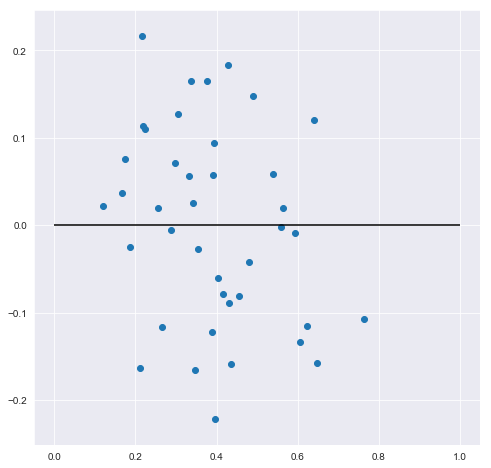

In [39]:
plt.scatter(clf.predict(X_train), clf.predict(X_train)-y_train)
plt.hlines(y=0, xmin=0, xmax=1)